In [ ]:
#pip install pillow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download color images from the BSD dataset and storing to drive and getting from it: 


In [ ]:
# Get image names from a GDrive directory

import os

path = '/content/drive/MyDrive/image_ee610'

imageNames = []

for i in os.scandir(path):
  imageNames.append(i.path)

imageNames

['/content/drive/MyDrive/image_ee610/ee610-1.jpg',
 '/content/drive/MyDrive/image_ee610/ee610-2.jpg',
 '/content/drive/MyDrive/image_ee610/ee610-3.jpg',
 '/content/drive/MyDrive/image_ee610/ee610-4.jpg',
 '/content/drive/MyDrive/image_ee610/ee610-5.jpg',
 '/content/drive/MyDrive/image_ee610/ee610-6.jpg',
 '/content/drive/MyDrive/image_ee610/test_123.jpg',
 '/content/drive/MyDrive/image_ee610/ee610-7.jpg',
 '/content/drive/MyDrive/image_ee610/ee610test-8.jpg',
 '/content/drive/MyDrive/image_ee610/ee610test-9.jpg',
 '/content/drive/MyDrive/image_ee610/ee610-10.jpg']

In [ ]:
len(imageNames)

11

Importing required libraries

In [ ]:
import torch
#torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
import PIL
from PIL import Image

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

#PyTorch libraries and modules
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss
from torch.optim import Adam, SGD

from torchvision import datasets, transforms 
from torch.utils import data

2. Prepare the training dataset: \\
a. Select the largest odd window size W, e.g. 13 or 27 \\
b. Prepare a few blur kernels and noise models \\
c. For each training image :- \\
  i. Degrade multiple times using different blur kernels and noise models \\
  ii. Display a few images to check if the degradation is realistic looking instead of too much or 
too little \\
 iii. For each degraded image version 
    1. Mine and store degraded patches of size WxW and central pixel of original patch 


In [ ]:
orig_img = image.imread(imageNames[5])
test_img = image.imread(imageNames[10])

In [ ]:
orig_img.dtype

dtype('uint8')

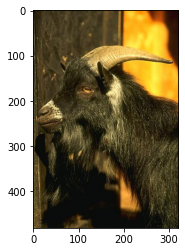

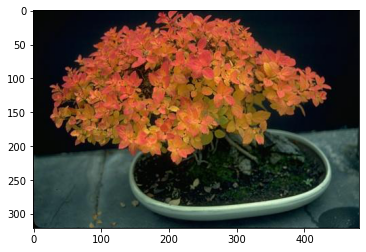

In [ ]:
plt.figure(1)
plt.subplot(111)
plt.imshow(orig_img)
plt.show()
plt.subplot(111)
plt.imshow(test_img)
plt.show()

In [ ]:
print(orig_img.shape)
print(test_img.shape)

(481, 321, 3)
(321, 481, 3)


In [ ]:
orig_img = cv2.resize(orig_img,(270,270))
test_img = cv2.resize(test_img,(270,270))

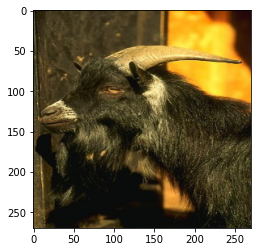

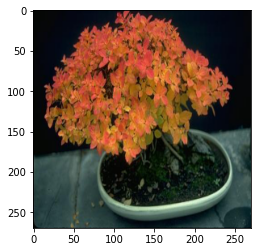

In [ ]:
plt.figure(2)
plt.subplot(111)
plt.imshow(orig_img)
plt.show()
plt.subplot(111)
plt.imshow(test_img)
plt.show()

In [ ]:
img1 = orig_img
img2 = test_img

In [ ]:
print(img1.shape)
print(img2.shape)

(270, 270, 3)
(270, 270, 3)


In [ ]:
print(type(img1))
print(type(img2))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
for i in range(2):
        blurred_img1 = cv2.GaussianBlur(img1,(27,27),0.01,0.010, cv2.BORDER_REPLICATE)
        blurred_img2 = cv2.GaussianBlur(img2,(27,27),0.01,0.010, cv2.BORDER_REPLICATE)
        gauss = np.random.normal(0,0.01,img1.size)
        #print(gauss.shape)     shape = (463203,)
        #print(gauss.dtype)     dtype = float64
        gauss = gauss.reshape(img1.shape[0],img1.shape[1],img1.shape[2]).astype('uint8')#noisy image
        img1 = cv2.add(blurred_img1,gauss)
        img2 = cv2.add(blurred_img2,gauss)
        

In [ ]:
noisy_img1 = img1
noisy_img2 = img2

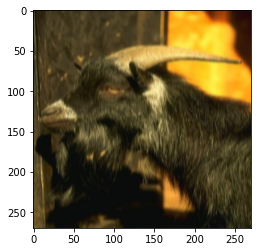

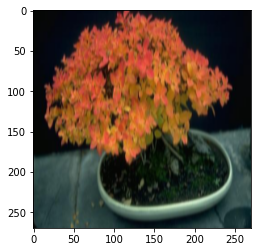

In [ ]:
plt.figure(3)
plt.subplot(111)
plt.imshow(noisy_img1)
plt.show()
plt.subplot(111)
plt.imshow(noisy_img2)
plt.show()

In [ ]:
from sklearn.feature_extraction import image

In [ ]:
patchesO1 = image.extract_patches_2d(orig_img,(27,27),max_patches=12000)/255
patchesN1 = image.extract_patches_2d(noisy_img1, (27,27),max_patches=12000)/255
patchesO2 = image.extract_patches_2d(test_img,(27,27),max_patches=12000)/255
patchesN2 = image.extract_patches_2d(noisy_img2, (27,27),max_patches=12000)/255
numPatches = len(patchesO1)
center_pix1 = np.empty((numPatches,3),dtype=float)
center_pix2 = np.empty((numPatches,3),dtype=float)
#patches_img = np.empty((numPatches,13,13,1), dtype=float)

for i in range(numPatches):
   center_pix1[i] = patchesO1[i][14,14]
   #a.append(center_pix1[i])
   center_pix2[i] = patchesO2[i][14,14]
#print(center_pix)

In [ ]:
patchesO1.shape

(12000, 27, 27, 3)

In [ ]:
len(center_pix1)

12000

In [ ]:
# b = []
# for i in range(numPatches):
#   diff = patchesO1[0][7,7] - center_pix1[0]
#   b.append(diff)

In [ ]:
# center_pix1[0]

In [ ]:
# center_pix1 = np.resize(center_pix1,(118,118,3))
# plt.imshow(center_pix1)
# plt.show()

In [ ]:
# center_pix1 = np.resize(center_pix1,(1,1,3))

In [ ]:
#center_pix1.shape

In [ ]:
#center_pix = center_pix.astype('float')

In [ ]:
patchesN1 = patchesN1.reshape(12000,3,27,27)
print(patchesN1.shape)
patchesN2 = patchesN2.reshape(12000,3,27,27)
print(patchesN2.shape)

(12000, 3, 27, 27)
(12000, 3, 27, 27)


In [ ]:
center_pix1 = center_pix1.reshape(12000,3,1,1)
center_pix2 = center_pix2.reshape(12000,3,1,1)
print(center_pix1.shape)
print(center_pix2.shape)

(12000, 3, 1, 1)
(12000, 3, 1, 1)


In [ ]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(patchesN1, center_pix1, test_size = 0.2)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((9600, 3, 27, 27), (9600, 3, 1, 1)), ((2400, 3, 27, 27), (2400, 3, 1, 1)))

In [ ]:
#  train_x = train_x[0:500]
#  train_y = train_y[0:500]
#  val_x = val_x[0:500]
#  val_y = val_y[0:500]
test_x = patchesN2
test_y = center_pix2

In [ ]:
print(test_x.shape)
print(test_y.shape)

(12000, 3, 27, 27)
(12000, 3, 1, 1)


In [ ]:
# train_x = train_x.astype('double')
# val_x = val_x.astype('double')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# converting training images into torch format
#train_x = train_x.reshape(54000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
#train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([9600, 3, 27, 27]), torch.Size([9600, 3, 1, 1]))

In [ ]:
val_x  = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)
# shape of validation data
val_x.shape, val_y.shape

(torch.Size([2400, 3, 27, 27]), torch.Size([2400, 3, 1, 1]))

In [ ]:
test_x  = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)
# shape of validation data
test_x.shape, test_y.shape

(torch.Size([12000, 3, 27, 27]), torch.Size([12000, 3, 1, 1]))

In [ ]:
train_x.dtype

torch.float64

In [ ]:
print(type(test_x))
print(test_x.dtype)

<class 'torch.Tensor'>
torch.float64


In [ ]:
train_x = train_x.double()
val_x  = val_x.double()
train_y = train_y.double()
val_y = val_y.double()
test_x = test_x.double()
test_y = test_y.double()

3. Train a regression model: \\
a. Select a window size w less than or equal to the largest window size W. \\
b. Select a machine learning model (nonlinear regression), e.g. support vector regression, random 
forest regression, neural network regression, or convolutional neural network. \\
c. Write a function to read only the w×w central pixels as input, and (optionally) pre-process them (e.g. make it zero mean and unit variance, or work in HSI space). \\
d. In python, train a regression model to predict the clean (optionally, normalized) central pixel.  \\
e. Monitor the normalized mean square error or mean absolute error for validation data. \\
f. Observe if models over-fits. If so, then implement early stopping. \\
g. Experiment with different choices, e.g. window size, machine learning models, capacity of models 
(e.g. tree depth, SVR penalty, number of hidden nodes in NN, number of layers and kernels in CNN, 
etc.) to find a reasonable model with small normalized RMSE, e.g. less than 1% or 2%.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.c1 = nn.Conv2d(3,16,13)
    self.bn1 = nn.BatchNorm2d(16)
    self.c2 = nn.Conv2d(16,32,9)
    self.bn2 = nn.BatchNorm2d(32)
    self.c3 = nn.Conv2d(32,64,5)
    self.bn3 = nn.BatchNorm2d(64)
    self.c4 = nn.Conv2d(64,128,3)
    self.bn4 = nn.BatchNorm2d(128)
    self.c5 = nn.Conv2d(128,256,1)
    self.c6 = nn.Conv2d(256,3,1)
    self.drop = nn.Dropout2d(p=0.25)
    self.double()

  def forward(self,x):
                                        
    x = self.bn1(F.relu(self.c1(x)))    
    x = self.bn2(F.relu(self.c2(x)))    
    x = self.bn3(F.relu(self.c3(x)))
    x = self.bn4(F.relu(self.c4(x)))      
    x = F.relu(self.c5(x))              
    x = self.c6(x)                      
    print(x.shape)
    return x
model = Net().to(device)
# image=torch.randn(1,3,27,27).to(device)

In [ ]:
 #model = model.float()

In [ ]:
# from torchsummary import summary
# model = Net().to(device)
# summary(model, (3, 13, 13))

In [ ]:
  # defining the model
model = Net().to(device)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)
# defining the loss function
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
criterion = RMSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (c1): Conv2d(3, 16, kernel_size=(13, 13), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (c6): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
  (drop): Dropout2d(p=0.25, inplace=False)
)


In [ ]:
def train(s):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # getting the testing set
    # x_test, y_test = Variable(test_x), Variable(test_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
        # x_test = x_test.cuda()
        # y_test = y_test.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    ot.append(output_train)
    output_val = model(x_val)
    ov.append(output_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()

    #if epoch%2 ==0:
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    

In [ ]:
# defining the number of epochs
n_epochs = 45
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# empty list to store predicted value of training data
ot = []
ov = []
# training the model
for epoch in range(n_epochs):
    train(epoch)
# print(ot[0])
# print(ov[0])

torch.Size([9600, 3, 1, 1])
torch.Size([2400, 3, 1, 1])
Epoch :  1 	 loss : tensor(0.3809, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)
torch.Size([9600, 3, 1, 1])
torch.Size([2400, 3, 1, 1])
Epoch :  2 	 loss : tensor(0.3439, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)
torch.Size([9600, 3, 1, 1])
torch.Size([2400, 3, 1, 1])
Epoch :  3 	 loss : tensor(0.3222, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)
torch.Size([9600, 3, 1, 1])
torch.Size([2400, 3, 1, 1])
Epoch :  4 	 loss : tensor(0.3072, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)
torch.Size([9600, 3, 1, 1])
torch.Size([2400, 3, 1, 1])
Epoch :  5 	 loss : tensor(0.2952, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)
torch.Size([9600, 3, 1, 1])
torch.Size([2400, 3, 1, 1])
Epoch :  6 	 loss : tensor(0.2848, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward0>)
torch.Size([9600, 3, 1, 1])
torch.Size([2400, 3, 1, 1])
Epoch :  7 	 loss : 

RuntimeError: ignored

In [ ]:
# # plotting the training and validation loss
# plt.plot(train_losses, label='Training loss')
# plt.plot(val_losses, label='Validation loss')
# plt.legend()
# plt.show()

In [ ]:
#SAVING FINAL MODEL

PATH2 = './sample_data/FinalModelCNN.pth'
torch.save(model.state_dict(), PATH2)

In [ ]:
#loading ptocedure from path
model = Net().to(device)
model.load_state_dict(torch.load(PATH2))

Calculating the overall MSE Loss


In [ ]:
# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
predictions = output.cpu()

# accuracy on training set
print("MSE Loss is: ", criterion(train_y, predictions))

# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())
predictions = output.cpu()

# accuracy on training set
print("RMSE is: ", criterion(val_y, predictions))

Testing our model on test data

In [ ]:
yp_out = model(test_x.cuda())

In [ ]:
# accuracy on test set
yp_out= yp_out.cpu()
print("Model RMSE on new data is: ", criterion(test_y, yp_out))

I have used pytorch CNN model for restoring image from central pixel of degraded patch. By using the window size of 13x13. Due to this , I am getting loss which is greater as compared to I got by using 27x27 window size. I have trained the model by using gpu which is provided by colab itself. Due to gpu , we are getting output faster as compared to other techniques.I faced the problem of storage also while training model due to less availability of RAM so tried to run it by using various accounts.\\
By using random forest regression model we can get good accuracy but the time requirement for training model is too high so pytorch is advantageous over here.

For real time image

In [ ]:
# from matplotlib import image
# real_img = image.imread('/content/sample_data/a4aaacaf85abed276a14763f4ce118f7.jpg')

In [ ]:
#real_img.dtype